# Character-Level Recurrent Neural Network

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras

In [47]:
#
# Load and pre-process data
#
SAMPLES_COUNT = 10_000
DATA_PATH = './data/deu.txt'

UNKNOWN_TOKEN = '\r'
START_TOKEN = '\t'
END_TOKEN = '\n'

def count_words(str):
    return len(str.split())

def clean_text(str):
    #characters = [s for s in str if s.isalnum() or s in ['.', '!', '?', "'", ' ']]
    #return ''.join(characters).strip()
    return str.strip()

def append_tokens(str):
    return f"{START_TOKEN}{str}{END_TOKEN}"

data = pd.read_csv(DATA_PATH, sep='\t', header=None, names=['en', 'de'], usecols=[0,1])
data['de'] = data['de'].apply(clean_text)
data['en'] = data['en'].apply(clean_text)
data['en'] = data['en'].apply(append_tokens)
data['en_wc'] = data['en'].apply(count_words)
data['de_wc'] = data['de'].apply(count_words)
data['en_len'] = data['en'].apply(len)
data['de_len'] = data['de'].apply(len)

# data = data[(data['en_wc'] <= 4) & (data['de_wc'] <= 4)] # randomly selected values
data = data[:SAMPLES_COUNT].reset_index()

In [48]:
data

,index,en,de,en_wc,de_wc,en_len,de_len
0,0,\tGo.\n,Geh.,1,1,5,4
1,1,\tHi.\n,Hallo!,1,1,5,6
2,2,\tHi.\n,Grüß Gott!,1,2,5,10
3,3,\tRun!\n,Lauf!,1,1,6,5
4,4,\tRun.\n,Lauf!,1,1,6,5
...,...,...,...,...,...,...,...
9995,9995,\tTom rose to go.\n,Tom stand auf um zu gehen.,4,6,17,26
9996,9996,\tTom rushed off.\n,Tom eilte davon.,3,3,17,16
9997,9997,\tTom said hello.\n,Tom sagte Hallo.,3,3,17,16
9998,9998,\tTom sat calmly.\n,Tom saß ruhig da.,3,4,17,17


In [49]:
#
# Build vocabulary and tokenizers
#

def create_vocabulary(df, source_column, initial_vocabulary = {}):
    token_to_index = initial_vocabulary.copy()
    
    for row in df.iterrows():
        source = row[1][source_column]

        for c in source:
            if c not in token_to_index:
                token_to_index[c] = len(token_to_index)
                
    index_to_token = { index: token for token, index in token_to_index.items() }
    
    return token_to_index, index_to_token
    
input_token_to_index = {}
input_token_to_index[' '] = 0
# input_token_to_index[UNKNOWN_TOKEN] = 1
input_token_to_index, input_index_to_token = create_vocabulary(data, 'de', input_token_to_index)

output_token_to_index = {}
output_token_to_index[' '] = 0
output_token_to_index[START_TOKEN] = 1
output_token_to_index[END_TOKEN] = 2
#output_token_to_index[UNKNOWN_TOKEN] = 3
output_token_to_index, output_index_to_token = create_vocabulary(data, 'en', output_token_to_index)

In [50]:
samples_count = len(data.index)
input_length = data.max()['de_len']
output_length = data.max()['en_len']
input_vocab_size = len(input_index_to_token)
output_vocab_size = len(output_index_to_token)

print(f"Available records: {samples_count}")
print(f"Input vocabulary size: {input_vocab_size}")
print(f"Output vocabulary size: {output_vocab_size}")
print(f"Max input length: {input_length}")
print(f"Max output length: {output_length}")

Available records: 10000
Input vocabulary size: 83
Output vocabulary size: 73
Max input length: 43
Max output length: 17


In [51]:
#
# Transform data to arrays
#

encoder_input_data = np.zeros((samples_count, input_length, input_vocab_size), dtype="float32")

decoder_input_data = np.zeros((samples_count, output_length, output_vocab_size), dtype="float32")
decoder_target_data = np.zeros((samples_count, output_length, output_vocab_size), dtype="float32")

for i, row in data.iterrows():
    sample_input = row['de']
    sample_output = row['en']
    
    for j in range(len(sample_input)):
        c = sample_input[j]
        idx = input_token_to_index[c]
        
        encoder_input_data[i, j, idx] = 1.0
        
    encoder_input_data[i, j + 1 :, 0] = 1.0
        
    for j in range(len(sample_output)):
        c = sample_output[j]
        idx = output_token_to_index[c]
        
        decoder_input_data[i, j, idx] = 1.0
        if j > 0:
            decoder_target_data[i, j - 1, idx] = 1.0
            
    decoder_input_data[i, j + 1 :, 0] = 1.0
    decoder_target_data[i, j:, 0] = 1.0


def transform_input_text(data, column = 'de'):
    result = np.zeros((len(data.index), input_length, input_vocab_size), dtype="float32")
    
    for i, row in data.iterrows():
        text = row[column]
        
        for j in range(len(text)):
            c = text[j]
            idx = input_token_to_index[c] if c in input_token_to_index else input_token_to_index[UNKNOWN_TOKEN]
            
            result[i, j, idx] = 1.0
            
        result[i, j + 1 :, 0] = 1.0
        
    return result

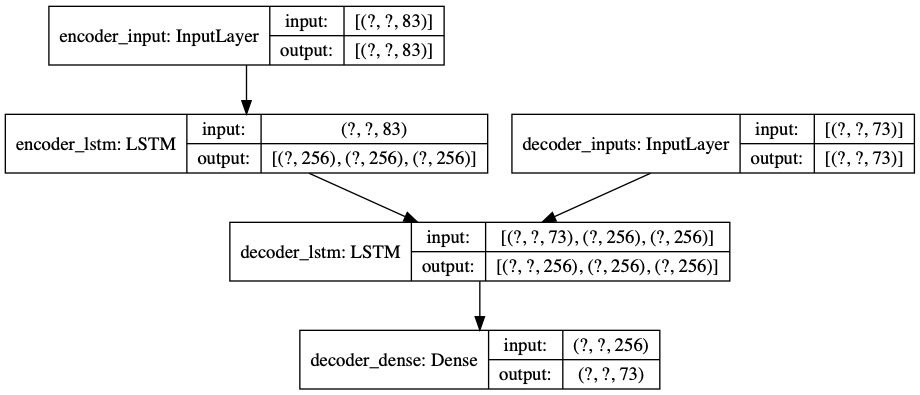

In [52]:
#
# Create model
#
LSTM_UNITS = 256

encoder_inputs = keras.Input(shape=(None, input_vocab_size), name='encoder_input')
encoder_outputs, encoder_state_h, encoder_state_c = keras.layers.LSTM(LSTM_UNITS, return_state=True, name='encoder_lstm')(encoder_inputs)

decoder_inputs = keras.Input(shape=(None, output_vocab_size), name='decoder_inputs')
decoder_lstm_output, _, _ = keras.layers.LSTM(
    LSTM_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')(
    decoder_inputs, initial_state=[encoder_state_h, encoder_state_c])

decoder_outputs = keras.layers.Dense(output_vocab_size, activation='softmax', name='decoder_dense')(decoder_lstm_output)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
keras.utils.plot_model(model, show_shapes=True)

In [53]:
batch_size = 64
epochs = 100

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 14s 112ms/step - loss: 2.4198 - accuracy: 0.3580 - val_loss: 2.6537 - val_accuracy: 0.2481
Epoch 2/100
125/125 [==============================] - 13s 106ms/step - loss: 1.9609 - accuracy: 0.4727 - val_loss: 2.0640 - val_accuracy: 0.4348
Epoch 3/100
125/125 [==============================] - 13s 104ms/step - loss: 1.6271 - accuracy: 0.5391 - val_loss: 1.8323 - val_accuracy: 0.4746
Epoch 4/100
125/125 [==============================] - 13s 105ms/step - loss: 1.5056 - accuracy: 0.5637 - val_loss: 1.7447 - val_accuracy: 0.5011
Epoch 5/100
125/125 [==============================] - 16s 128ms/step - loss: 1.4067 - accuracy: 0.5838 - val_loss: 1.8564 - val_accuracy: 0.4563
Epoch 6/100
125/125 [==============================] - 14s 110ms/step - loss: 1.3331 - accuracy: 0.6016 - val_loss: 1.6490 - val_accuracy: 0.5064
Epoch 7/100
125/125 [==============================] - 15s 117ms/step - loss: 1.2657 - accuracy: 0.6209 - val_loss: 1.5312 -

Epoch 57/100
125/125 [==============================] - 15s 116ms/step - loss: 0.4007 - accuracy: 0.8755 - val_loss: 1.7335 - val_accuracy: 0.6307
Epoch 58/100
125/125 [==============================] - 15s 121ms/step - loss: 0.3954 - accuracy: 0.8768 - val_loss: 1.7023 - val_accuracy: 0.6322
Epoch 59/100
125/125 [==============================] - 14s 112ms/step - loss: 0.3916 - accuracy: 0.8773 - val_loss: 1.7656 - val_accuracy: 0.6305
Epoch 60/100
125/125 [==============================] - 14s 113ms/step - loss: 0.3873 - accuracy: 0.8788 - val_loss: 1.7098 - val_accuracy: 0.6366
Epoch 61/100
125/125 [==============================] - 14s 109ms/step - loss: 0.3817 - accuracy: 0.8801 - val_loss: 1.7128 - val_accuracy: 0.6358
Epoch 62/100
125/125 [==============================] - 14s 111ms/step - loss: 0.3774 - accuracy: 0.8816 - val_loss: 1.7034 - val_accuracy: 0.6373
Epoch 63/100
125/125 [==============================] - 14s 110ms/step - loss: 0.3738 - accuracy: 0.8826 - val_loss: 1

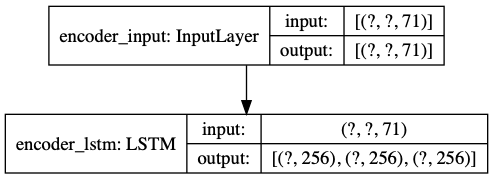

In [9]:
encoder_inputs = model.get_layer('encoder_input').input
encoder_outputs, state_h_enc, state_c_enc = model.get_layer('encoder_lstm').output
encoder_model = keras.Model(encoder_inputs, [state_h_enc, state_c_enc])

keras.utils.plot_model(encoder_model, show_shapes=True)

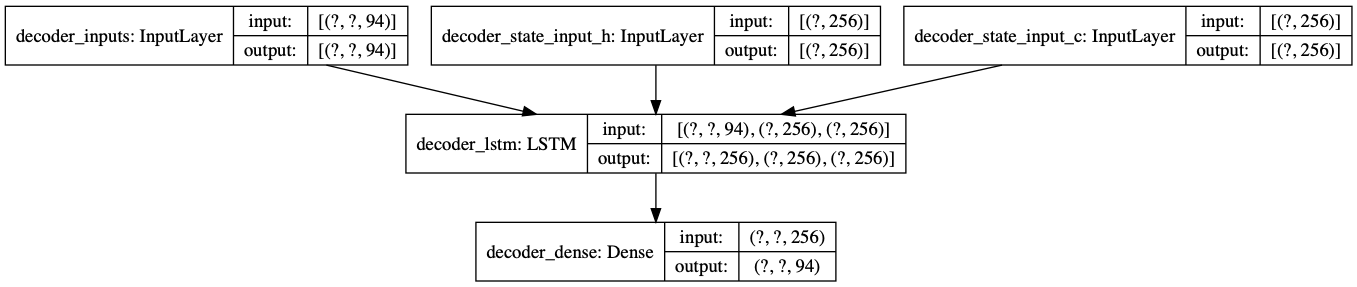

In [10]:
decoder_inputs = model.get_layer('decoder_inputs').input
decoder_state_input_h = keras.Input(shape=(LSTM_UNITS), name='decoder_state_input_h')
decoder_state_input_c = keras.Input(shape=(LSTM_UNITS), name='decoder_state_input_c')

decoder_outputs, decoder_state_h, decoder_state_c = \
    model.get_layer('decoder_lstm')(decoder_inputs, initial_state=[decoder_state_input_h, decoder_state_input_c])
decoder_output_dense = model.get_layer('decoder_dense')(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs, decoder_state_input_h, decoder_state_input_c], 
    [decoder_output_dense, decoder_state_h, decoder_state_c])

keras.utils.plot_model(decoder_model, show_shapes=True)

In [22]:
#
# Run prediction
#

def predict(text):
    text_df = pd.DataFrame(data={ 'de': [clean_text(text)] })
    
    encoder_input = transform_input_text(text_df)
    states = encoder_model.predict(encoder_input)

    decoded_output_data = np.zeros((1, 1, output_vocab_size), dtype="float32")
    decoded_output_data[0,0, output_token_to_index[START_TOKEN]] = 1.0

    end = False
    result = ""
    
    while not end:
        output_tokens, h, c = decoder_model.predict([ decoded_output_data ] + states)
        sampled_idx = np.argmax(output_tokens[0, -1, :])
        sampled_char = output_index_to_token[sampled_idx]
        result += sampled_char
        
        if sampled_char == END_TOKEN or len(result) > output_length:
            end = True
            
        decoded_output_data = np.zeros((1, 1, output_vocab_size), dtype="float32")
        decoded_output_data[0, 0, sampled_idx] = 1.0
        states = [h, c]
        
    return result

In [39]:
text_df = pd.DataFrame(data={ 'de': ['Go.'] })
encoder_input = transform_input_text(text_df)

1
2
3


In [40]:
encoder_input[0,0,:]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [29]:
encoder_input_data[0,0,:]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [37]:
input_token_to_index[' ']

0

In [44]:
for idx, row in data[1001:1020].iterrows():
    text = row['de']
    
    print("-")
    print("Input sequence:", text)
    print("Decodes sequence:", predict(text))

-
Input sequence: Step back.
Decodes sequence: Reculez !

-
Input sequence: Step back.
Decodes sequence: Reculez !

-
Input sequence: Stop that!
Decodes sequence: Arrêtez !

-
Input sequence: Stop that.
Decodes sequence: Arrêtez ça !

-
Input sequence: Stop that.
Decodes sequence: Arrêtez ça !

-
Input sequence: Stop that.
Decodes sequence: Arrêtez ça !

-
Input sequence: Stop them.
Decodes sequence: Arrêtez-les.

-
Input sequence: Take care!
Decodes sequence: Prends soin de toi !

-
Input sequence: Take care!
Decodes sequence: Prends soin de toi !

-
Input sequence: Take care.
Decodes sequence: Prenez soin de vous.

-
Input sequence: Take care.
Decodes sequence: Prenez soin de vous.

-
Input sequence: Take mine.
Decodes sequence: Prends les miennes.

-
Input sequence: Take mine.
Decodes sequence: Prends les miennes.

-
Input sequence: Take mine.
Decodes sequence: Prends les miennes.

-
Input sequence: Take mine.
Decodes sequence: Prends les miennes.

-
Input sequence: Take mine.
Decod